In [9]:
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
from causalimpact import CausalImpact
import datetime
from datetime import date

In [3]:
# connect to impala
%run -i 'db/impala_connect.py'

In [4]:
oos_qry = """
select 
weekenddt
,drm.distributorretailmarketid
,sum(oos.averagestr13weekbblqty * oos.outofstockcnt) oos_vol
from core.distroskuweekoutofstockfact oos
inner join core.customer cust on oos.shiptodistributornbr = cust.shiptocustomernbr
inner join core.drmdim drm on drm.customernbr = cust.customernbr
inner join core.osku o on oos.orderableskuid = o.orderableskuid
where oos.validdistributoroskupaircnt = 1
-- Same conditions here that are used to define the dependent variable
and (o.nationalbrandsegmentnme in('economy brands', 'malt liquor','ice', 'near premium') and o.orderableskuid != 701057)
group by 1, 2
;"""

In [5]:
qry = """
select
dd.mondayweekenddt weekenddt
,s.distributorretailmarketid drm
-- Economy (not special light)
,sum(case when o.nationalbrandsegmentnme in('economy brands', 'malt liquor','ice', 'near premium') and o.orderableskuid != 701057 then bblqty else 0 end) y
-- premium light
,sum(case when o.nationalbrandsegmentnme = 'premium light' then bblqty else 0 end) X0
-- craft
,sum(case when o.nationalbrandsegmentnme = 'craft' then bblqty else 0 end) X1
-- import
,sum(case when o.nationalbrandsegmentnme = 'import' then bblqty else 0 end) X2
-- premium
,sum(case when o.nationalbrandsegmentnme = 'premium' then bblqty else 0 end) X3
-- fmb
,sum(case when o.nationalbrandsegmentnme = 'flavored malt beverage' then bblqty else 0 end) X4
-- hard cider
,sum(case when o.nationalbrandsegmentnme = 'hard cider' then bblqty else 0 end) X5
from core.str s 
inner join core.osku o on s.orderableskuid = o.orderableskuid
inner join core.day_dim dd on dd.calendardate = s.invoicedt
inner join core.retail_outlet r on s.retailoutletid = r.retailoutletid
-- filter to only bottles and cans
where o.containertypenme in ('can', 'bottle')
and r.premisetypenme = 'off'
and year(s.invoicedt) >= 2019
and s.distributorretailmarketid in (
    select distinct distributorretailmarketid 
    from core.str s 
    inner join core.osku o on s.orderableskuid = o.orderableskuid
    inner join core.retail_outlet r on s.retailoutletid = r.retailoutletid
    where o.nationalbrandsegmentnme in('economy brands', 'malt liquor','ice', 'near premium')
    and o.containertypenme in ('can', 'bottle')
    and r.premisetypenme = 'off'
    and year(s.invoicedt) >= 2019 
)
group by 1,2
;
"""
df = impala_select(cnxn, qry)
df['weekenddt'] = pd.to_datetime(df['weekenddt'], format='%Y-%m-%d')

In [10]:
# create list of dates we want to include (impute with 0)
start = datetime.date(2019,1,6)
end = datetime.date(2020,9,6)
numweeks = int(round(abs((start - end).days)/7))+1
date_list = [start + datetime.timedelta(days=7*i) for i in range(numweeks)]

# define pre and post period
pre = np.where([i < datetime.date(2020,5,24) for i in date_list])
post = np.where([i >= datetime.date(2020,5,24) for i in date_list])
pre = [int(min(pre[0])),int(max(pre[0]))]
post = [int(min(post[0])),int(max(post[0]))]

In [11]:
# set of drms to loop over
drms = list(set(df['drm']))

In [14]:
# select distributor
drm_i = drms[15]
df_i = df[df['drm'] == drm_i].sort_values(by=['weekenddt'])
# select valid date ranges and remove ID columns
df_i = df_i[df_i['weekenddt'].isin(date_list)].reset_index().drop(['weekenddt','drm','index'], axis = 1)

# run the Causal Impact Code
imp = CausalImpact(df_i, pre, post, prior_level_sd=None)

# store results
results_i = imp.summary_data.reset_index().rename(columns = {'index':'metric'})
results_i['drm'] = drm_i
results_i['p_value'] = imp.p_value

In [15]:
results_i

metric    average   cumulative  drm  p_value
0            actual  48.081929   769.310866   28      0.0
1         predicted  60.287180   964.594876   28      0.0
2   predicted_lower  57.897842   926.365478   28      0.0
3   predicted_upper  62.758117  1004.129871   28      0.0
4        abs_effect -12.205251  -195.284010   28      0.0
5  abs_effect_lower -14.676188  -234.819006   28      0.0
6  abs_effect_upper  -9.815913  -157.054612   28      0.0
7        rel_effect  -0.202452    -0.202452   28      0.0
8  rel_effect_lower  -0.243438    -0.243438   28      0.0
9  rel_effect_upper  -0.162819    -0.162819   28      0.0

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    48.08              769.31
Prediction (s.d.)         60.29 (1.24)       964.59 (19.84)
95% CI                    [57.9, 62.76]      [926.37, 1004.13]

Absolute effect (s.d.)    -12.21 (1.24)      -195.28 (19.84)
95% CI                    [-14.68, -9.82]    [-234.82, -157.05]

Relative effect (s.d.)    -20.25% (2.06%)    -20.25% (2.06%)
95% CI                    [-24.34%, -16.28%] [-24.34%, -16.28%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


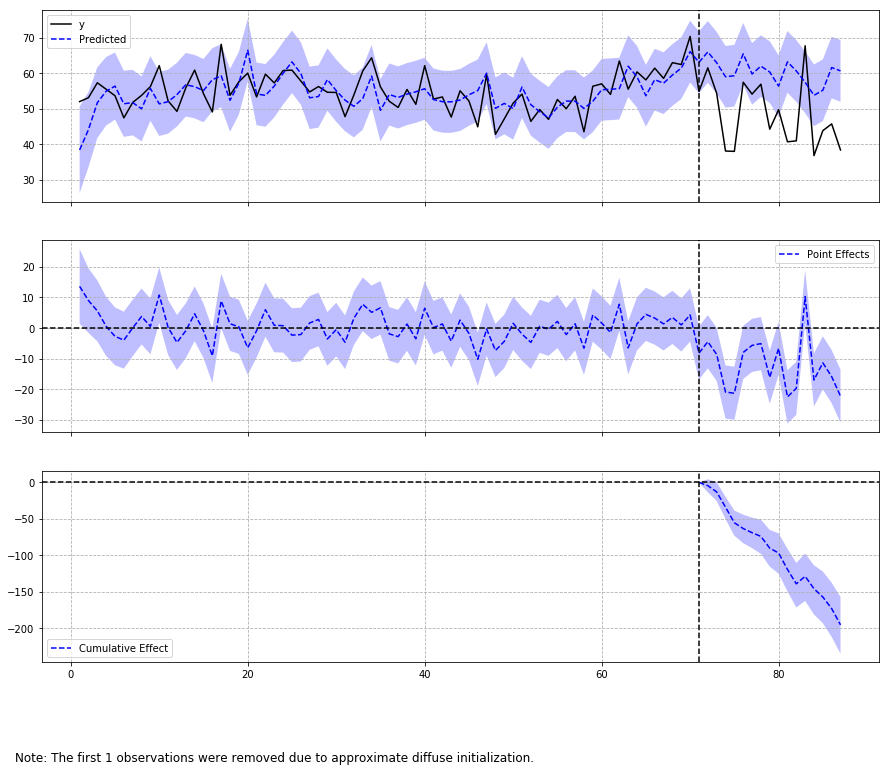

In [16]:
print(imp.summary())
imp.plot()

In [ ]:
imp